In [ ]:
!pip install h3 --user
!pip install h3ronpy --user

In [57]:
import h3
from h3ronpy import raster
import rasterio as rio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
from rasterstats import gen_zonal_stats, gen_point_query
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import json
import os
from shapely.geometry import shape, mapping, box, Point, LinearRing, Polygon


In [58]:
prod_raster = '../../datasets/processed/h3_test/cotton_production_ind.tif'

test_area = (65,4,100,40)

In [59]:
!gdalinfo $prod_raster

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/h3_test/cotton_production_ind.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.097781811000004)
Pixel Size = (0.083333340000000,-0.083333340000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0977818) (179d59'30.00"W, 83d 5'52.01"N)
Lower Left  (-179.9916667, -55.9022293) (179d59'30.00"W, 55d

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 1668, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333334, 0.0, -179.99166665,
       0.0, -0.08333334, 83.097781811), 'tiled': False, 'interleave': 'band'}


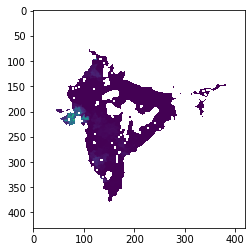

,h3index,value,geometry
0,595544245482291199,1.184053,"POLYGON ((92.55260 24.03562, 92.57008 24.27717..."
1,596176017991663615,51.209873,"POLYGON ((76.58980 16.09129, 76.59311 16.33240..."
2,595652263909785599,22.480604,"POLYGON ((72.74989 25.74265, 72.78305 25.51809..."
3,595560136861286399,0.003904,"POLYGON ((77.86239 29.34234, 77.87917 29.10794..."
4,595542604804784127,0.001181,"POLYGON ((86.47877 24.17735, 86.49094 24.41644..."


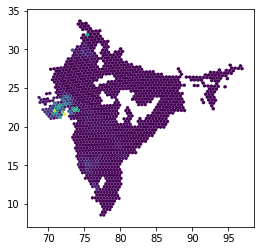

In [60]:
with rio.open(prod_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(src.read(1, window=window), transform, h3_resolution=4, nodata_value=int(src.profile['nodata']), compacted=False)

gdf.plot('value')
gdf.head()

In [ ]:
src=rio.open(prod_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array=src.read(window=window)
prod_df=array[0].ravel()
round(prod_df[prod_df > 0].mean(), 2)

In [ ]:
round(gdf['value'].mean(), 2)

### Risk map

In [ ]:
risk_raster = '../../datasets/processed/h3_test/wr_cotton_india.tif'

with rio.open(risk_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(src.read(1, window=window), transform, h3_resolution=4, nodata_value=int(src.profile['nodata']), compacted=False)

gdf.plot('value')
#gdf['h3index'] = gdf['h3index'].apply(hex)
gdf.head()

In [ ]:
src=rio.open(risk_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array=src.read(window=window)
risk_df=array[0].ravel()
print(round(risk_df[risk_df > 0].mean(), 3))

print(round(gdf['value'].mean(), 3))

## Impact map

In [ ]:
impact_raster = '../../datasets/processed/h3_test/water_impact_cotton_ind_m3yr.tif'

with rio.open(impact_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)
    print(src.profile)
    rio.plot.show(src.read(window=window, masked=True))
    gdf = raster.raster_to_geodataframe(src.read(1, window=window), transform, h3_resolution=4, nodata_value=int(src.profile['nodata']), compacted=False)

gdf.plot('value')
#gdf['h3index'] = gdf['h3index'].apply(hex)
gdf.head()

In [ ]:
src=rio.open(impact_raster)
window = rio.windows.from_bounds(*test_area, src.transform)

array=src.read(window=window)
impact_df=array[0].ravel()
print(round(impact_df[risk_df > 0].mean(), 3))

print(round(gdf['value'].mean(), 3))

## Convert rasters to H3

Define function

In [64]:
prod_raster = '../../datasets/processed/h3_test/cotton_production_ind.tif'
with rio.open(prod_raster) as src:
    window = rio.windows.from_bounds(*test_area, src.transform)
    transform = rio.windows.transform(window, src.transform)

    gdf = raster.raster_to_geodataframe(src.read(1, window=window), transform, h3_resolution=6, nodata_value=int(src.profile['nodata']), compacted=False)

gdf['h3index'] = gdf['h3index'].apply(lambda x: hex(x)[2:])
gdf.index = gdf['h3index']
gdf.drop(columns='h3index', inplace=True)
gdf

,value,geometry
h3index,,
866189027ffffff,0.712279,"POLYGON ((78.25212 12.86780, 78.25278 12.90284..."
863ca836fffffff,0.000107,"POLYGON ((86.32643 23.76689, 86.32815 23.80118..."
8642eaa77ffffff,381.802185,"POLYGON ((71.60891 24.54213, 71.61411 24.51055..."
8642eab5fffffff,381.802185,"POLYGON ((71.56876 24.58568, 71.57398 24.55409..."
863d88917ffffff,0.000840,"POLYGON ((80.66357 26.34612, 80.66450 26.31387..."
...,...,...
863ca4a47ffffff,0.000895,"POLYGON ((82.14283 24.63598, 82.14402 24.66958..."
863ca4a5fffffff,0.000895,"POLYGON ((82.17309 24.58642, 82.17428 24.62003..."
8660a60c7ffffff,53.594898,"POLYGON ((78.80086 16.33037, 78.80160 16.36521..."


In [65]:
gdf.to_file('../../datasets/processed/h3_test/cotton_production_ind.geojson', driver="GeoJSON")

In [66]:
gdf.drop('geometry', axis=1).to_csv('../../datasets/processed/h3_test/cotton_production_ind.csv', index=True)